In [21]:
from google.colab import drive
# drive.mount('/content/drive/MyDrive/IITP/sohyun/creditcard_prediction/data')
drive.mount('/content/drive')

%cd drive/MyDrive/IITP/sohyun/TimeSeriesAnomaly/data/modify

# !pip install wandb -qqq
# import wandb
# wandb.login()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1j1N0u5t0l99N_wfSd5UZvnhugzn5g_NC/TimeSeriesAnomaly/data/modify


In [45]:
import matplotlib.pyplot as plt
import easydict
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#---# Window #---#
def sliding_window(arr, window_size, stride):
  start_pt = 0
  total_data = []
  while(True) :
    if len(arr) < (start_pt + window_size) : break
    data = arr[start_pt:start_pt+window_size]
    start_pt += stride
    total_data.append(data)
  return total_data

def drawing(original, anomaly, model) :
  plt.figure(figsize=(30,5))
  plt.title(f"{model}")
  plt.plot(original, markersize=1)
  plt.plot(anomaly, marker='.', markersize=2, color='r', linestyle='None')

  # plt.plot(original[62100:65400], markersize=1, marker=".")
  # plt.plot(anomaly[62100:65400], markersize=1, color="r", marker=".")

  #---# 실제 anomaly 값 구간 #---#
  a = np.linspace(62200, 65200)
  plt.fill_between(a, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(a, -1, 4, color='green', alpha=0.3)
  b = np.linspace(95600, 99200)
  plt.fill_between(b, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(b, -1, 4, color='green', alpha=0.3)
  c = np.linspace(148400, 152200)
  plt.fill_between(c, 0, 2000, color='green', alpha=0.3)
  # plt.fill_between(c, -1, 4, color='green', alpha=0.3)

  plt.show()
  plt.clf()

def get_anomaly_df(if_anomalies) : #### 수정해야 할 부분 #######################
  # temp = pd.DataFrame(index=range(0, len(test_scale)), columns={'Fu'})
  temp = pd.DataFrame(index=range(0, len(test_scale)), columns={'Fu'})
  
  for i in if_anomalies.index : 
    # case1
    # temp.loc[i*config.stride : (i*config.stride + (config.window_size - 1))] = pd.DataFrame(if_anomalies.loc[i,:])

    # case2
    k = 0
    for j in range(i*config.stride, (i*config.stride + config.window_size)) : ## 수정해야
      temp.loc[j] = if_anomalies.loc[i, k]
      k += 1
    
  # anomaly = temp.dropna()
  anomaly = temp.dropna()

  return anomaly

def get_anomaly_time(if_anomalies, data_length) : 
  temp = pd.DataFrame(index=range(0, len(test_scale)), columns={'Fu'})

  # print("if_anomalies\n", if_anomalies.loc[196, :])
  for i in range(data_length) : 
    if i in if_anomalies.index :
      k = 0
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        temp.loc[j] = if_anomalies.loc[i, k]
        k += 1
    else :
      k = 0
      for j in range(i*config.stride, (i*config.stride + config.window_size)) : 
        temp.loc[j] = np.nan
        k += 1
    
  anomaly = temp.dropna()
  return anomaly

def calculate(true_list, pred_list, test_len) :
  pred_set_anomaly = set(pred_list.index.tolist())
  pred_set_normal = set(range(test_len)) - pred_set_anomaly
  true_set_anomaly = set(np.where(np.array(true_list) == 1)[0].tolist()) # true에서 anomaly
  true_set_normal = set(np.where(np.array(true_list) == 0)[0].tolist()) # true에서 normal

  recall = len(pred_set_anomaly.intersection(true_set_anomaly))/ len(true_set_anomaly)
  # accuracy = len(pred_set_anomaly.intersection(true_set_anomaly)) / len(pred_set_anomaly.union(true_set_anomaly))

  accuracy = (len(pred_set_anomaly.intersection(true_set_anomaly)) + len(pred_set_normal.intersection(true_set_normal))) / test_len

  print("true set: ", len(true_set_anomaly))
  print("anomaly set: ", len(pred_set_anomaly))
  
  return recall, accuracy

In [46]:
def models(config, train, test, total) :
  ##################
  #---# DBSCAN #---#
  ##################
  '''
  min_samples : 핵심 포인트를 중심점으로 간주하는 주변 지역의 표본 수
  eps : the maximum distance between two samples for one to be considered as in the neighborhood of the other (default : 0.5) / 핵심 포인트를 중심으로 측정되는 유클리디언 거리값
  metric : the metric to use when calculating distance between instances in a feature array (default : "euclidean")
  '''
  from sklearn.cluster import DBSCAN
  clf_dbscan = DBSCAN(eps=17, metric="euclidean", min_samples=80)
  clf_dbscan.fit(total)
  scores = clf_dbscan.fit_predict(test)
  DBSCAN_anomalies = pd.Series([0 if i != -1 else 1 for i in scores])
  DBSCAN_anomalies = test[DBSCAN_anomalies == 1]
  anomaly = get_anomaly_df(DBSCAN_anomalies)

  drawing(test_scale, anomaly, 'DBSCAN')
  recall_timeX, accuracy_timeX = calculate(true_label, anomaly, test_len)
  print(f"<timeX>\n===== RECALL =====\n{recall_timeX}\n===== ACCURACY =====\n{accuracy_timeX}")

  anomaly = get_anomaly_time(DBSCAN_anomalies, len(scores))
  drawing(test_scale, anomaly, 'DBSCAN')
  # for i in anomaly.index : pred_label[i] = 1
  recall_time, accuracy_time = calculate(true_label, anomaly, test_len)
  print(f"<time>\n===== RECALL =====\n{recall_time}\n===== ACCURACY =====\n{accuracy_time}")
  
  ################################
  #---# IF (IsolationForest) #---#
  ################################
  '''
  max_samples : the number of samples to draw from X to train each base estimator
  contamination : the amount of contamination of the data set
  '''
  from sklearn.ensemble import IsolationForest
  clf_if = IsolationForest(max_samples=100, contamination=config.contamination) # 비율을 어떻게 할 것인가?
  clf_if.fit(test.to_numpy()) # clf.fit(train_scale)
  # if_scores = clf_if.decision_function(test.to_numpy()) ##
  if_anomalies = clf_if.predict(test.to_numpy())
  if_anomalies = pd.Series(if_anomalies).replace([-1,1],[1,0])
  if_anomalies = test[if_anomalies==1]

  anomaly = get_anomaly_df(if_anomalies)
  drawing(test_scale, anomaly, 'IsolationForest')
  recall_timeX, accuracy_timeX = calculate(true_label, anomaly, test_len)
  print(f"<timeX>\n===== RECALL =====\n{recall_timeX}\n===== ACCURACY =====\n{accuracy_timeX}")

  anomaly = get_anomaly_time(if_anomalies, len(scores))
  drawing(test_scale, anomaly, 'IsolationForest')
  recall_time, accuracy_time = calculate(true_label, anomaly, test_len)
  print(f"<time>\n===== RECALL =====\n{recall_time}\n===== ACCURACY =====\n{accuracy_time}")


  ######################################
  #---# LOF (Local Outlier Factor) #---#
  ######################################
  '''
  n_neighbors : number of neighbors to use by default for kneighbors queries
  '''
  from sklearn.neighbors import LocalOutlierFactor
  clf_lof = LocalOutlierFactor(n_neighbors=100, contamination=config.contamination, novelty=True)
  # y_pred = clf.fit_predict(total_scale)
  clf_lof.fit(test.to_numpy())
  pred = clf_lof.predict(test.to_numpy()) 
  LOF_Scores = clf_lof.negative_outlier_factor_
  LOF_pred=pd.Series(pred).replace([-1,1],[1,0])
  LOF_anomalies = test[LOF_pred==1]
  anomaly = get_anomaly_df(LOF_anomalies)
  drawing(test_scale, anomaly, 'Local Outlier Factor')
  recall, accuracy = calculate(true_label, anomaly, test_len)
  print(f"===== RECALL =====\n{recall}\n===== ACCURACY =====\n {accuracy}")

  ##################################
  #---# EE (Elliptic Envelope) #---#
  ##################################
  from sklearn.covariance import EllipticEnvelope
  clf = EllipticEnvelope(contamination=config.contamination, random_state=0, support_fraction=0.999)
  clf.fit(total)
  # ee_scores = pd.Series(clf.decision_function(total_scale)) 
  ee_pred = clf.predict(test)
  ee_anomalies = test[ee_pred==-1]
  # drawing(test_scale, ee_anomalies, 'Elliptic Envelope')
  anomaly = get_anomaly_df(ee_anomalies)
  drawing(test_scale, anomaly, 'Elliptic Envelope')
  recall_timeX, accuracy_timeX = calculate(true_label, anomaly, test_len)
  print(f"===== RECALL =====\n{recall_timeX}\n===== ACCURACY =====\n{accuracy_timeX}")

  anomaly = get_anomaly_time(ee_anomalies, len(ee_pred))
  drawing(test_scale, anomaly, 'Elliptic Envelope')
  recall_time, accuracy_time = calculate(true_label, anomaly, test_len)
  print(f"===== RECALL =====\n{recall_time}\n===== ACCURACY =====\n{accuracy_time}")

  #########################
  #---# One-Class SVM #---#
  #########################
  '''
  nu : an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
  gamma : kernel coefficient for 'rbf', 'poly', and 'sigmoid'
  '''
  from sklearn import svm
  clf = svm.OneClassSVM(nu=config.contamination, gamma=.005) #nu=.02, gamma=.005 # kernel을 멀로써야하는지? # linear로 한번 해보기 kernel='poly'
  clf.fit(train) # total
  pred = clf.predict(test)
  svm_anomalies = test[pred==-1]
  anomaly = get_anomaly_df(svm_anomalies)

  drawing(test_scale, anomaly, 'One-Class SVM')
  recall_timeX, accuracy_timeX = calculate(true_label, anomaly, test_len)
  print(f"<timeX>\n===== RECALL =====\n{recall_timeX}\n===== ACCURACY =====\n{accuracy_timeX}")

  anomaly = get_anomaly_time(svm_anomalies, len(pred))
  drawing(test_scale, anomaly, 'One-Class SVM')
  recall_time, accuracy_time = calculate(true_label, anomaly, test_len)
  print(f"<time>\n===== RECALL =====\n{recall_time}\n===== ACCURACY =====\n{accuracy_time}")

  return recall_timeX, accuracy_timeX, recall_time, accuracy_time

window : 600, stride : 200, contamination : 0.0001


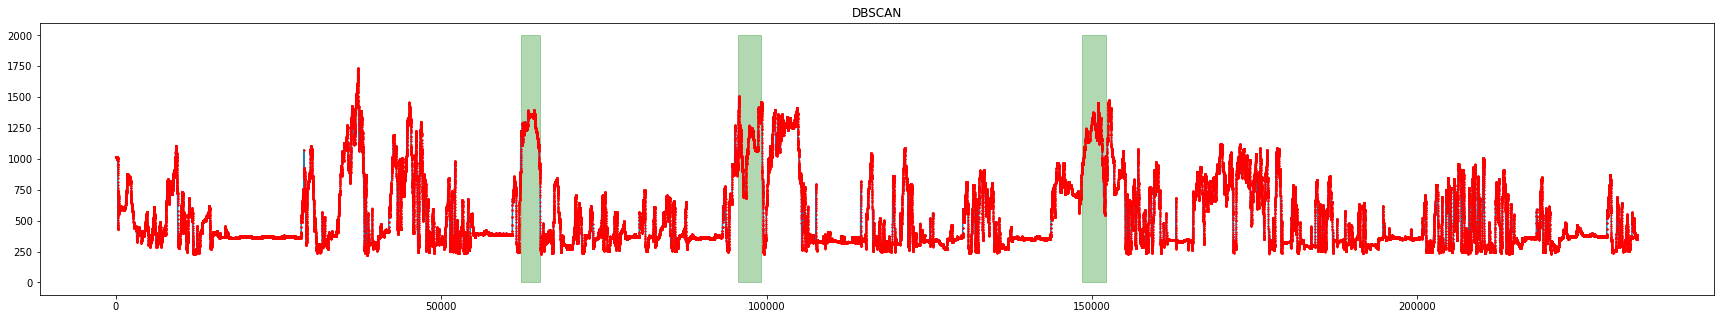

true set:  10700
anomaly set:  233800
<timeX>
===== RECALL =====
1.0
===== ACCURACY =====
0.045777855716137086


<Figure size 432x288 with 0 Axes>

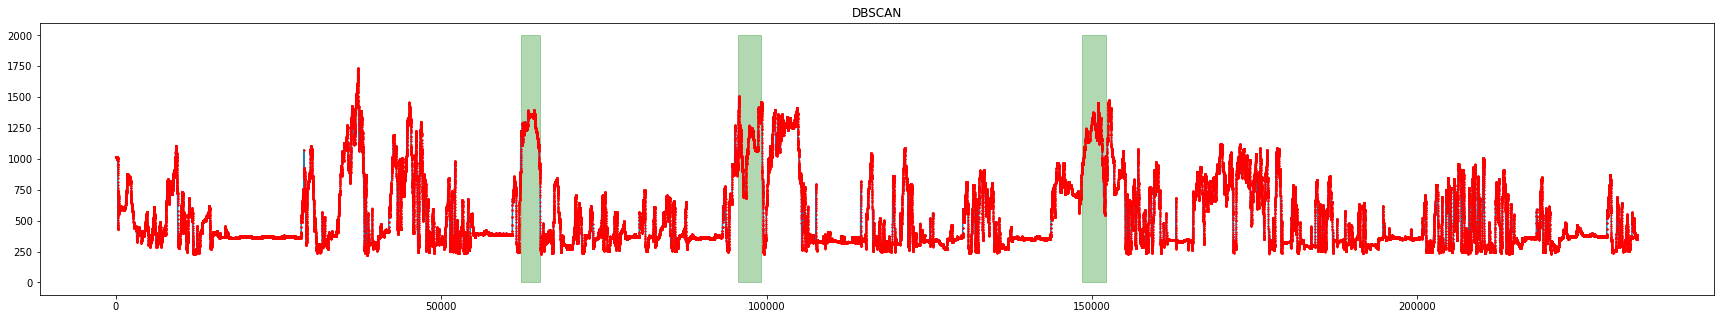

true set:  10700
anomaly set:  233800
<time>
===== RECALL =====
1.0
===== ACCURACY =====
0.045777855716137086


<Figure size 432x288 with 0 Axes>

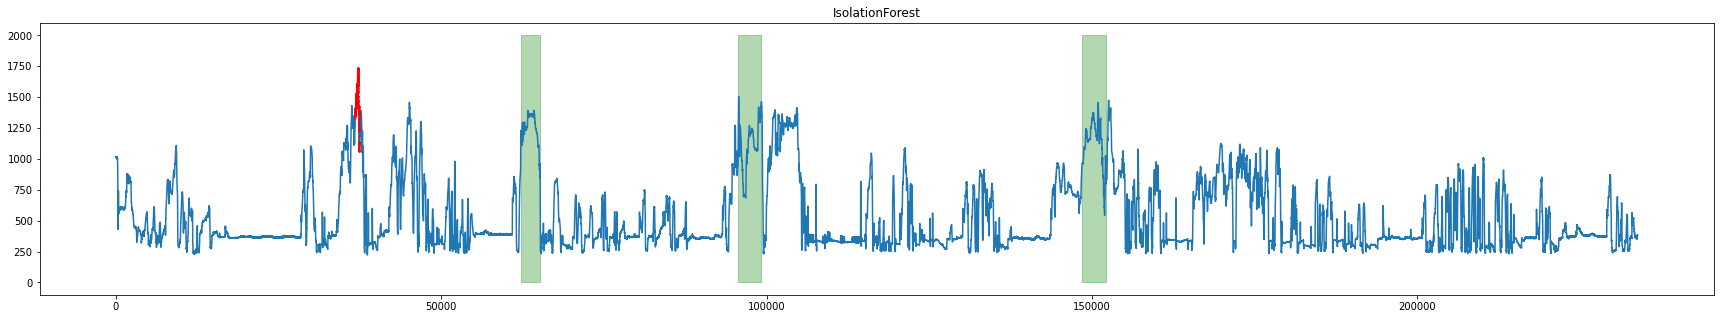

true set:  10700
anomaly set:  600
<timeX>
===== RECALL =====
0.0
===== ACCURACY =====
0.9516687125485986


<Figure size 432x288 with 0 Axes>

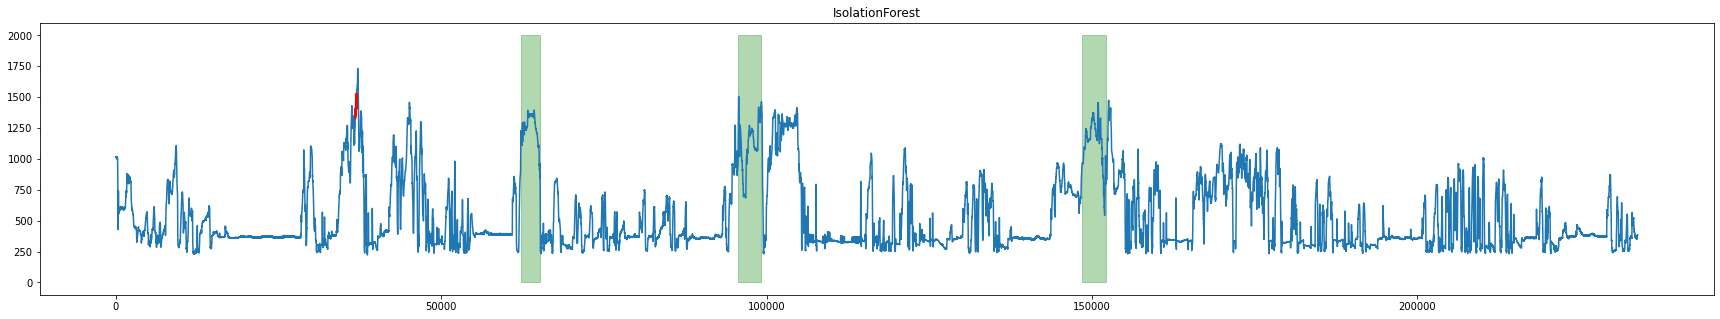

true set:  10700
anomaly set:  200
<time>
===== RECALL =====
0.0
===== ACCURACY =====
0.9533795545822765


<Figure size 432x288 with 0 Axes>

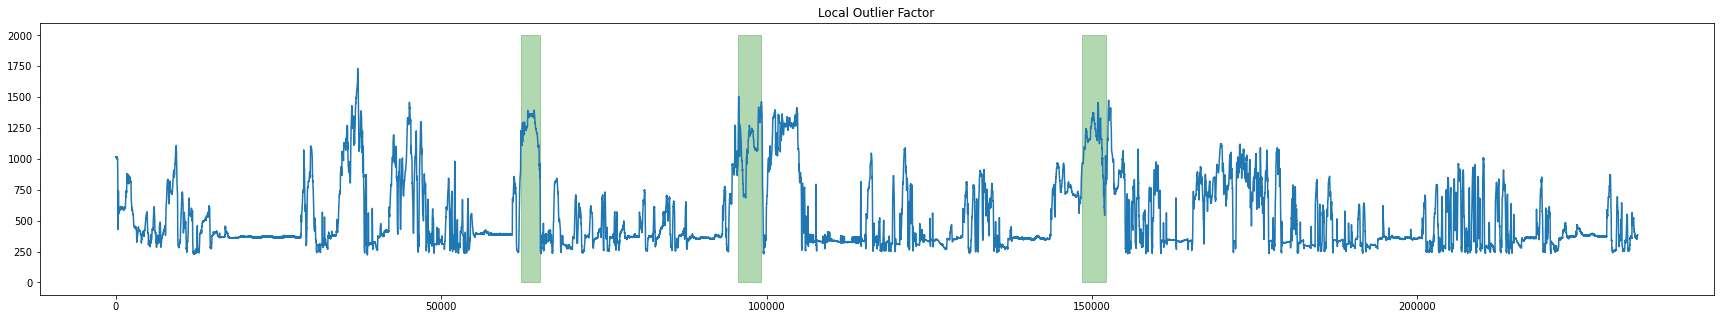

true set:  10700
anomaly set:  0
===== RECALL =====
0.0
===== ACCURACY =====
 0.9542349755991155


<Figure size 432x288 with 0 Axes>

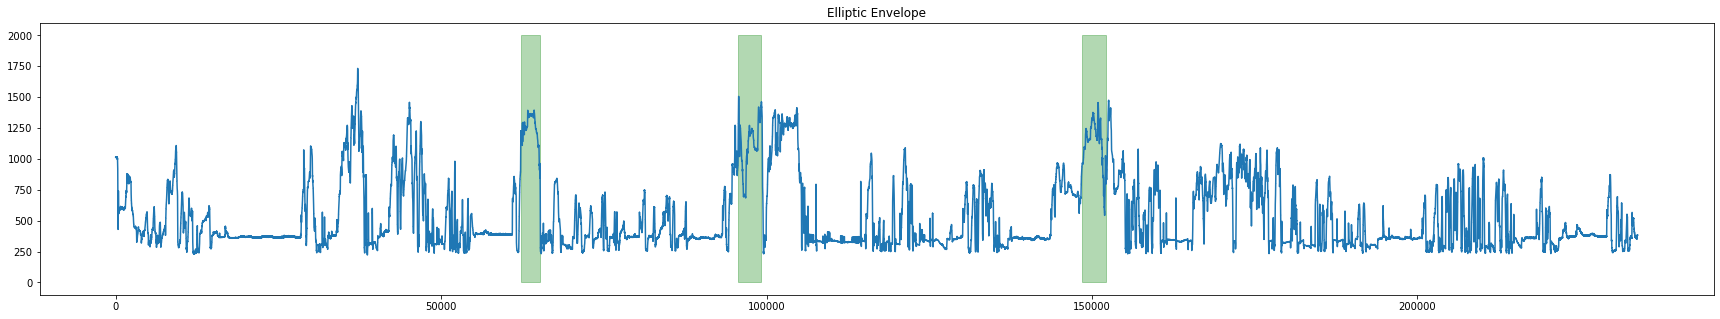

true set:  10700
anomaly set:  0
===== RECALL =====
0.0
===== ACCURACY =====
0.9542349755991155


<Figure size 432x288 with 0 Axes>

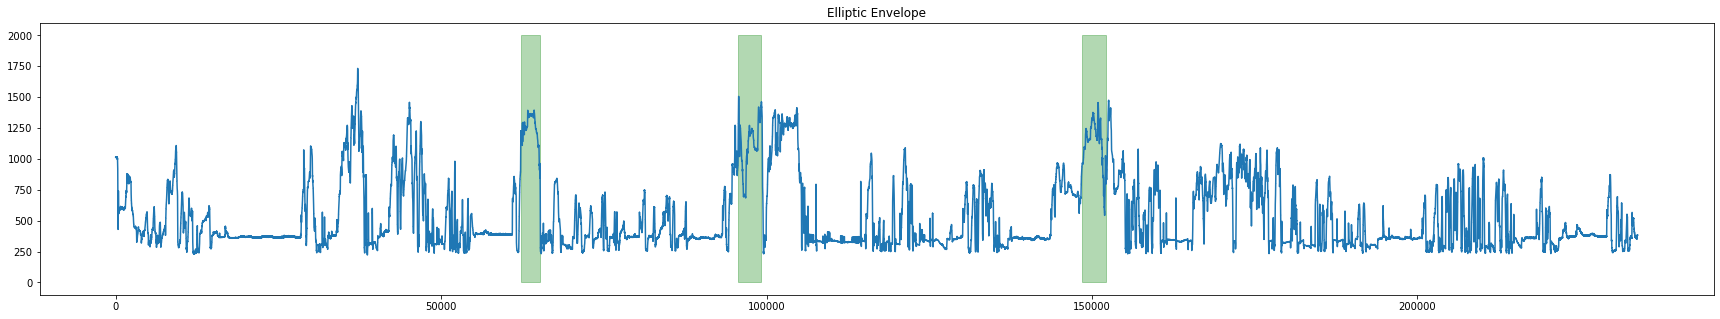

true set:  10700
anomaly set:  0
===== RECALL =====
0.0
===== ACCURACY =====
0.9542349755991155


<Figure size 432x288 with 0 Axes>

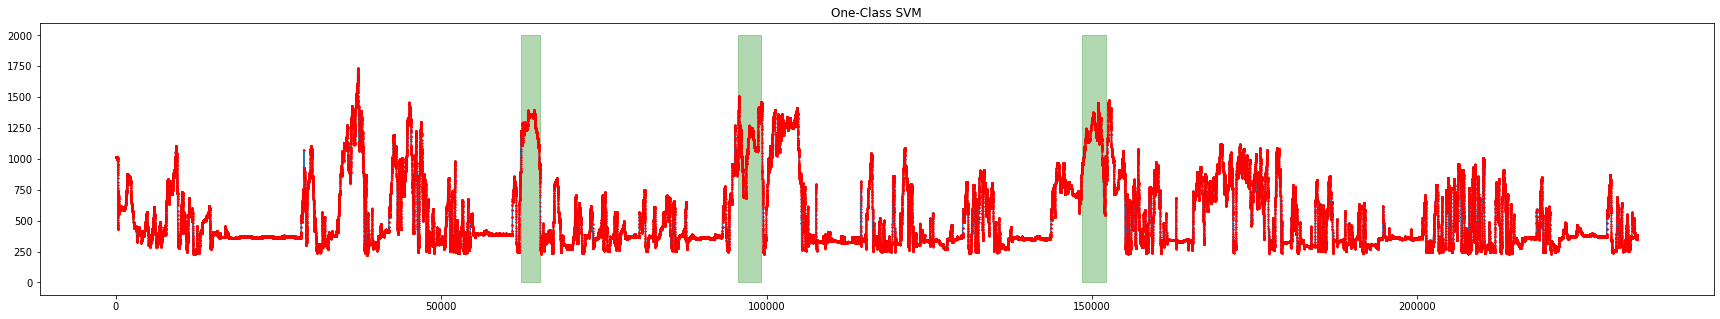

true set:  10700
anomaly set:  233800
<timeX>
===== RECALL =====
1.0
===== ACCURACY =====
0.045777855716137086


<Figure size 432x288 with 0 Axes>

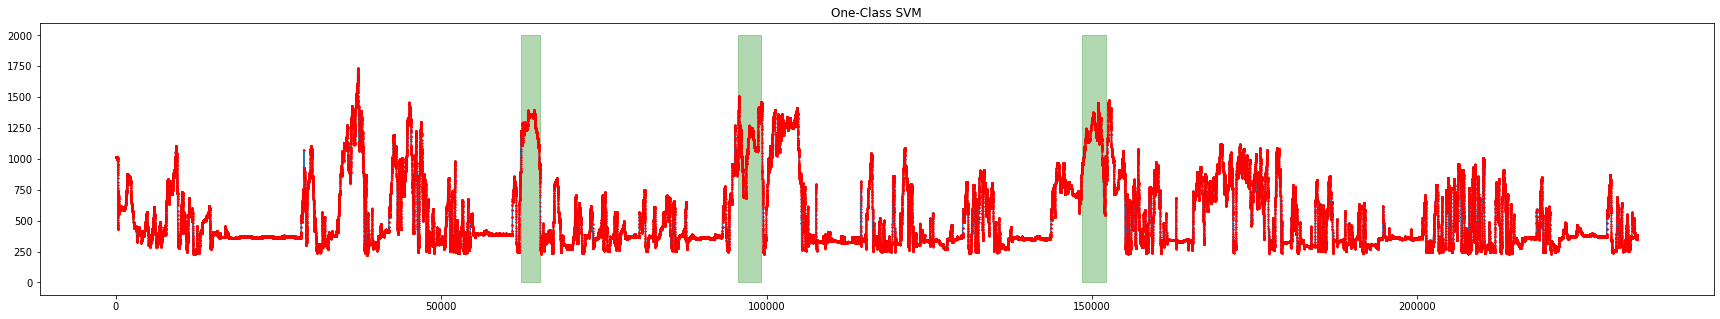

true set:  10700
anomaly set:  233800
<time>
===== RECALL =====
1.0
===== ACCURACY =====
0.045777855716137086


<Figure size 432x288 with 0 Axes>

In [47]:
# windows = [900, 1000]
# strides = [600, 700, 800]
# contaminations = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35] # [0.001, 0.005, 0.01, 0.05]
windows = [600]
strides = [200]
contaminations = [0.0001]

#---# LOAD npy file #---#
# Fu_20_normal = np.load('Fu_20_normal.npy')
# Fu_21_normal = np.load('Fu_21_normal.npy')
# Fu_21_abnormal = np.load('Fu_21_abnormal.npy')
# Fu_22_normal = np.load('Fu_22_normal.npy')
# Fu_22_abnormal = np.load('Fu_22_abnormal.npy')

# Fu_20_normal_10 = np.load('Fu_20_normal_10.npy')
# Fu_21_normal_10 = np.load('Fu_21_normal_10.npy')
# Fu_21_abnormal_10 = np.load('Fu_21_abnormal_10.npy')
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

train = pd.DataFrame(Fu_22_normal_10, columns=['Fu'])
test = pd.DataFrame(Fu_22_abnormal_10, columns=['Fu'])
test_len = len(test)
total = pd.DataFrame(pd.concat([train, test], axis=0))

train_scale = train['Fu'].values
test_scale = test['Fu'].values
total_scale = total['Fu'].values

#####################
#---# Normalize #---#
#####################
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist()
# train_scale = scaler.transform(train); train_scale = pd.DataFrame(train_scale, columns=['Fu'])['Fu'].values.tolist()
# test_scale = scaler.transform(test); test_scale = pd.DataFrame(test_scale, columns=['Fu'])['Fu'].values.tolist()

# print(pd.DataFrame(train_scale).shape)

#####################
#---# list 만들기 #---#
#####################
true_label = [0 for i in range(test_len)]
true_label[62200:65300] = [1 for i in range(62200,65300)]
true_label[95600:99300] = [1 for i in range(95600,99300)]
true_label[148400:152300] = [1 for i in range(148400,152300)]

results = pd.DataFrame(columns = ['window_size','stride','contamination','timeX-recall','timeX-accuracy','time-recall','time-accuracy']); idx = 0
for w in windows :
  for s in strides :
    for c in contaminations :
      config = easydict.EasyDict({
          "mode" : 'train',
          # "mode" : "test",
          "window_size" : w,
          "stride" : s,
          # "threshold" : 0.7,
          "contamination" : c ############ 
      })
      print(f"window : {w}, stride : {s}, contamination : {c}")

      train = pd.DataFrame(sliding_window(train_scale, config.window_size, config.stride))
      test = pd.DataFrame(sliding_window(test_scale, config.window_size, config.stride))
      total = pd.DataFrame(sliding_window(total_scale, config.window_size, config.stride))

      recall_timeX, accuracy_timeX, recall_time, accuracy_time = models(config, train, test, total)
      # results.loc[idx] = [config.window_size, config.stride, config.contamination, recall_timeX, accuracy_timeX, recall_time, accuracy_time]; 
      idx += 1
# results.to_csv(f'svm-08261017_gamma0.01.csv', header = True, index = False)

In [15]:
import pandas as pd
import torch
import numpy as np
x = np.array(list(range(0, 100*50)))
x.shape = (100, 50)
x = pd.DataFrame(x)

In [ ]:
x

In [18]:
window_size = 12
windows_normal = x.values[np.arange(window_size)[None, :] + np.arange(x.shape[0]-window_size)[:, None]]
windows_normal.shape

(88, 12, 50)

In [19]:
windows_normal[0]

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
       [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
       [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
     

In [36]:
np.arange(x.shape[0]-window_size)[:, None].shape

(494988, 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


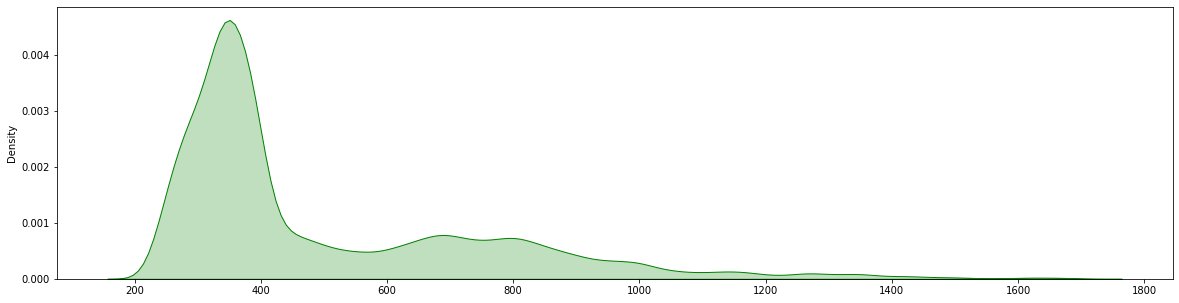

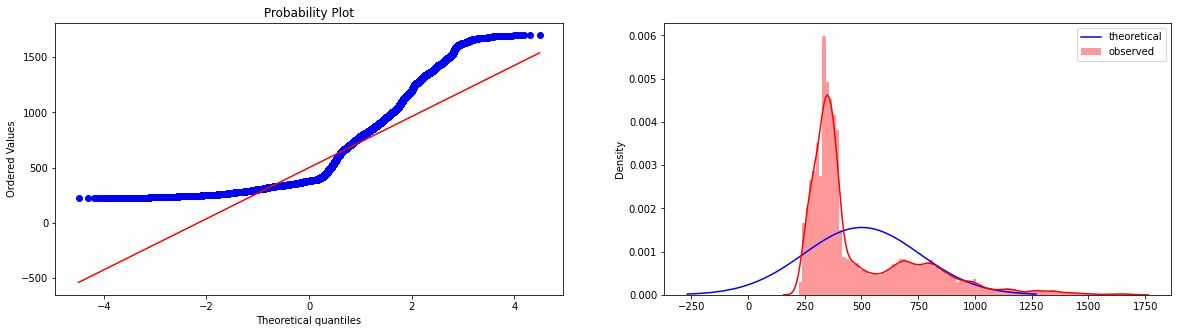

0.23198545205356114 0.0
0.8136009573936462 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
#---# raw 데이터 정규성 검정 #---# pca
import seaborn as sns
plt.figure(figsize=(20,5))
sns.kdeplot(data=Fu_22_normal_10, color="green", shade=True)

import scipy.stats as stats
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
stats.probplot(Fu_22_normal_10, dist=stats.norm, plot=ax1)
mu = Fu_22_normal_10.mean()
variance = Fu_22_normal_10.var()
sigma = variance ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x, mu, sigma), color = "blue", label = 'theoretical')
sns.distplot(ax=ax2, a = Fu_22_normal_10, bins = 100, color="red", label = 'observed')
ax2.legend()
plt.show()

#---# Kolmogorov-Smirnov Test #---#
test_stat, p_val = stats.kstest(Fu_22_normal_10, 'norm', args = (Fu_22_normal_10.mean(), Fu_22_normal_10.var() ** 0.5))
print(test_stat, p_val)

#---# Shapiro-Wilk Test #---#
test_stat, p_val = stats.shapiro(Fu_22_normal_10)
print(test_stat, p_val)

<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


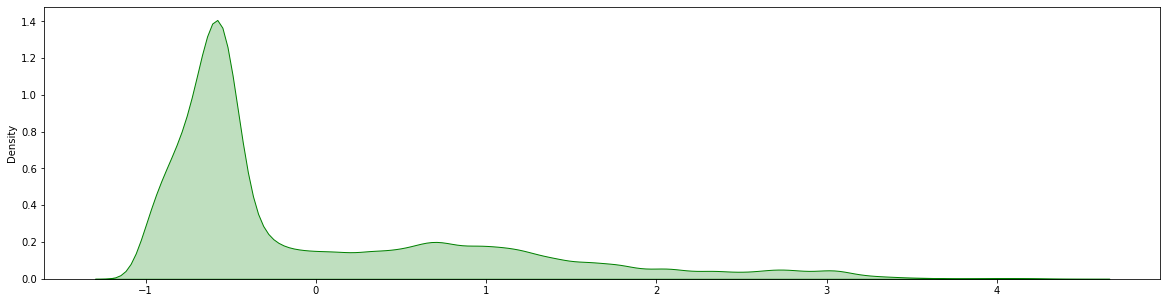

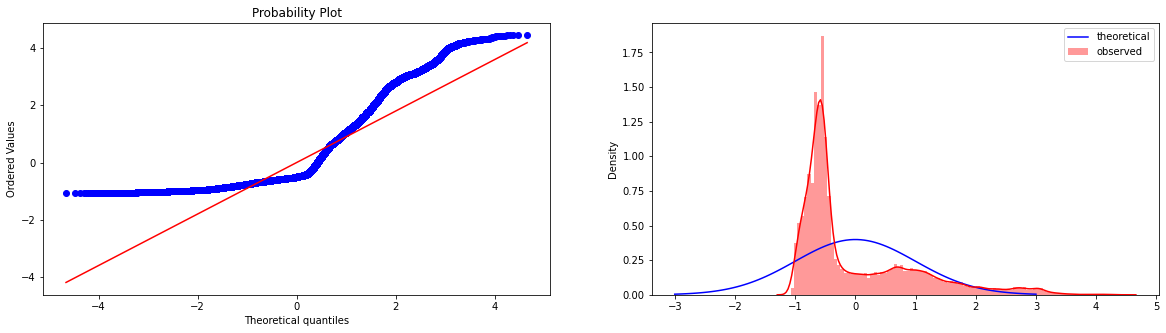

0.2368628671460884 0.0
0.8060868382453918 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
#---# normalization 후, 정규성 검정 #---#
Fu_22_normal_10 = np.load('Fu_22_normal_10.npy')
Fu_22_abnormal_10 = np.load('Fu_22_abnormal_10.npy')

train = pd.DataFrame(Fu_22_normal_10, columns=['Fu'])
test = pd.DataFrame(Fu_22_abnormal_10, columns=['Fu'])
test_len = len(test)
total = pd.DataFrame(pd.concat([train, test], axis=0))

scaler = StandardScaler()

total_scale = scaler.fit_transform(total); total_scale = pd.DataFrame(total_scale, columns=['Fu'])['Fu'].values.tolist()
total_scale = np.array(total_scale)
print(type(total_scale))

import seaborn as sns
plt.figure(figsize=(20,5))
sns.kdeplot(data=total_scale, color="green", shade=True)

import scipy.stats as stats
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
stats.probplot(total_scale, dist=stats.norm, plot=ax1)
mu = total_scale.mean()
variance = total_scale.var()
sigma = variance ** 0.5
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, stats.norm.pdf(x, mu, sigma), color = "blue", label = 'theoretical')
sns.distplot(ax=ax2, a = total_scale, bins = 100, color="red", label = 'observed')
ax2.legend()
plt.show()

#---# Kolmogorov-Smirnov Test #---#
test_stat, p_val = stats.kstest(total_scale, 'norm', args = (total_scale.mean(), total_scale.var() ** 0.5))
print(test_stat, p_val)

#---# Shapiro-Wilk Test #---#
test_stat, p_val = stats.shapiro(total_scale)
print(test_stat, p_val)